# Function Testing Notebook - Yong copy

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne

In [ ]:
# packageroot = Path('../../').resolve()
packageroot = Path('/mnt/isilon/marsh_single_unit/PythonEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

core.set_temp_directory('/mnt/isilon/marsh_single_unit/PythonEEG')

/Users/ohy2/Documents/GitHubRepo/PyEEG


/Users/ohy2/Documents/GitHubRepo/PyEEG/.venv_mouseEEG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
from typing import Literal, Optional, List, Dict, Any, Union, Tuple
from pathlib import Path

import mne
from mne.time_frequency import tfr_morlet

class MNEExperimentPlotter:
    """
    A class for creating various plots from a list of MNE objects with grouping capabilities.
    
    This class provides methods for creating different types of plots (evoked, TFR, etc.)
    from MNE data with consistent data processing, grouping, and contrasting.
    """

    def __init__(self, mne_objects: Union[mne.io.Raw, List[mne.io.Raw]]):
        """
        Initialize plotter with MNE Raw object(s).
        
        Parameters
        ----------
        mne_objects : mne.io.Raw or list[mne.io.Raw]
            Single MNE Raw object or list of MNE Raw objects
        """
        # Convert single MNE object to list
        if not isinstance(mne_objects, list):
            mne_objects = [mne_objects]
            
        self.mne_objects = mne_objects
        
        # Extract metadata from all objects
        self.metadata = []
        for obj in mne_objects:
            # Ensure temp dict exists
            if 'temp' not in obj.info:
                obj.info['temp'] = {}
            
            # Extract metadata from the object
            meta = {
                'animal_id': obj.info['temp'].get('animal_id', 'Unknown'),
                'file_path': obj.info['temp'].get('file_path', 'Unknown'),
                'sfreq': obj.info['sfreq'],
                'ch_names': obj.ch_names,
                'mne_obj': obj  # Store reference to the object itself
            }
            self.metadata.append(meta)
        
        # Collect all unique channel names
        self.all_channel_names = sorted(list(set([ch for obj in mne_objects for ch in obj.ch_names])))
        logging.info(f'all_channel_names: {self.all_channel_names}')


    def random_subsample_epochs(epochs: mne.Epochs, max_epochs=1000):
        """
        Randomly subsample epochs if there are more than max_epochs.
        
        Parameters
        ----------
        epochs : mne.Epochs
            The epochs object to potentially subsample
        max_epochs : int
            Maximum number of epochs to keep
            
        Returns
        -------
        mne.Epochs
            The original epochs object if len(epochs) <= max_epochs,
            otherwise a randomly subsampled version
        """
        if len(epochs) > max_epochs:
            # Get random indices for subsampling
            indices = np.random.choice(len(epochs), size=max_epochs, replace=False)
            epochs = epochs[indices]
        return epochs

    def rename_mne_elements(mne_obj, rename_channels=True, rename_events=True, method='abbrev'):
        """
        Rename channels and/or events in an MNE object using standardized naming conventions.
        
        Parameters
        ----------
        mne_obj : mne.io.Raw
            MNE Raw object to rename channels and/or events
        rename_channels : bool
            Whether to rename channels
        rename_events : bool
            Whether to rename events/annotations
        method : str, optional
            Method for renaming. Options:
            - 'abbrev': Use parse_chname_to_abbrev to create abbreviations
            - 'clean': Use clean_channel_name to simplify names
            
        Returns
        -------
        mne.io.Raw
            MNE Raw object with renamed elements
        """
        from pythoneeg.core.utils import parse_chname_to_abbrev, clean_channel_name
        import numpy as np
        
        # Helper function to apply the selected renaming method
        def apply_rename_method(name):
            if method == 'abbrev':
                return parse_chname_to_abbrev(name)
            elif method == 'clean':
                return clean_channel_name(name)
            else:
                return name
        
        # Rename channels if requested
        if rename_channels:
            # Create a dictionary mapping old names to new names
            rename_dict = {}
            for ch_name in mne_obj.ch_names:
                rename_dict[ch_name] = apply_rename_method(ch_name)
            
            # Rename the channels
            mne_obj.rename_channels(rename_dict)
            print(f"  ✓ Renamed {len(rename_dict)} channels using {method} method")
        
        # Rename events if requested
        if rename_events:
            # Check if there are annotations to rename
            if hasattr(mne_obj, 'annotations') and len(mne_obj.annotations) > 0:
                # Get unique annotation descriptions
                unique_descriptions = np.unique(mne_obj.annotations.description)
                
                # Create a mapping of old to new names
                rename_dict = {}
                for desc in unique_descriptions:
                    rename_dict[desc] = apply_rename_method(desc)
                
                # Apply the renaming
                new_descriptions = np.array([rename_dict.get(d, d) for d in mne_obj.annotations.description])
                mne_obj.annotations.description = new_descriptions
                
                print(f"  ✓ Renamed {len(rename_dict)} event types using {method} method")
            else:
                print("  ⚠ No annotations found to rename")
        
        return mne_obj

    def load_mne_objects(animal_ids, base_folder='./test-mnes', rename_channels=True, 
                    rename_events=True, fmin=1, fmax=50, downsample=None):
        """
        Load MNE objects from SpikeAnalysisResult files for specified animal IDs.
        
        Parameters
        ----------
        animal_ids : list of str
            List of animal IDs to load data for
        base_folder : str or Path
            Base folder containing the data files
        rename_channels : bool
            Whether to rename channels using standardized naming conventions
        rename_events : bool
            Whether to rename event IDs using standardized naming conventions
        fmin : float
            Lower frequency bound for bandpass filter (Hz)
        fmax : float
            Upper frequency bound for bandpass filter (Hz)
        downsample : float or None
            Target sampling frequency for downsampling (Hz).
            If None, no downsampling is performed.
            If specified and lower than the original sampling rate, the data is resampled.
            
        Returns
        -------
        list of mne.io.Raw
            List of loaded MNE Raw objects with metadata
        """
        import glob
        import os
        from pythoneeg.visualization import SpikeAnalysisResult
        
        # Create a list to store all mne objects
        mne_objects = []
        
        # Get all files for each animal ID
        for animal_id in animal_ids:
            # Find all files matching the pattern for this animal
            file_pattern = f'{base_folder}/{animal_id}*'
            animal_files = glob.glob(file_pattern)
            
            print(f"Found {len(animal_files)} files for {animal_id}:")
            for file in animal_files:
                print(f"  - {file}")
                
                # Load each file and add to our list
                try:
                    # Load the object
                    reconstruct_sas = SpikeAnalysisResult.load_fif_and_json(file)
                    mne_obj = reconstruct_sas.result_mne
                    
                    # Apply bandpass filter
                    mne_obj.filter(l_freq=fmin, h_freq=fmax, verbose=True)
                    print(f"  ✓ Applied bandpass filter: {fmin}-{fmax} Hz")
                    
                    # Apply downsampling if requested
                    if downsample is not None:
                        current_sfreq = mne_obj.info['sfreq']
                        if downsample < current_sfreq:
                            mne_obj.resample(downsample)
                            print(f"  ✓ Downsampled from {current_sfreq} Hz to {downsample} Hz")
                        else:
                            print(f"  ⚠ Requested downsample rate ({downsample} Hz) is >= current rate ({current_sfreq} Hz). Skipping.")
                    
                    # Rename channels and/or events if requested
                    mne_obj = MNEExperimentPlotter.rename_mne_elements(
                        mne_obj, 
                        rename_channels=rename_channels, 
                        rename_events=rename_events, 
                        method='abbrev'
                    )
                    
                    # Store basic metadata
                    if 'temp' not in mne_obj.info:
                        mne_obj.info['temp'] = {}
                    mne_obj.info['temp']['animal_id'] = animal_id
                    mne_obj.info['temp']['file_path'] = file
                    
                    # Add to our list
                    mne_objects.append(mne_obj)
                    print(f"  ✓ Successfully loaded")
                    
                except Exception as e:
                    print(f"  ✗ Error loading: {str(e)}")
        
        print(f"\nTotal MNE objects loaded: {len(mne_objects)}")
        return mne_objects

    def get_objects_by_group(self, group_key: str) -> Dict[str, List[mne.io.Raw]]:
        """
        Group MNE objects by a metadata key
        
        Parameters
        ----------
        group_key : str
            Metadata key to group by (e.g. 'animal_id')
            
        Returns
        -------
        Dict[str, List[mne.io.Raw]]
            Dictionary mapping group values to lists of MNE objects
        """
        groups = {}
        for meta in self.metadata:
            value = meta.get(group_key, 'Unknown')
            if value not in groups:
                groups[value] = []
            groups[value].append(meta['mne_obj'])
        return groups

    def create_epochs(self, tmin: float = -10, tmax: float = 5, tcrop=(-3, 3),
                  baseline: Tuple[Optional[float], Optional[float]] = (None, -5),
                  event_id: Optional[Dict[str, int]] = None) ->  Dict[str, List[mne.Epochs]]:
        """
        Create epochs for all MNE objects
        
        Parameters
        ----------
        tmin : float
            Start time before event
        tmax : float
            End time after event
        baseline : tuple
            Baseline correction period
        event_id : dict
            Event IDs to include
            
        Returns
        -------
        Dict[str, List[mne.Epochs]]
            Dictionary mapping animal_ids to lists of Epochs objects
        """
        grouped_epochs = {}
        
        for meta in self.metadata:
            animal_id = meta['animal_id']
            raw = meta['mne_obj']
            
            try:
                # Extract events from annotations
                events, event_dict = mne.events_from_annotations(raw)
                
                # Use provided event_id if given, otherwise use all events
                use_event_id = event_id if event_id else event_dict
                
                # Create epochs
                epochs = mne.Epochs(
                    raw, 
                    events, 
                    event_id=use_event_id,
                    tmin=tmin, 
                    tmax=tmax, 
                    baseline=baseline,
                    preload=True
                )

                epochs = self.random_subsample_epochs(epochs).load_data()
                epochs.crop(tmin=tcrop[0], tmax=tcrop[1])
                
                if animal_id not in grouped_epochs:
                    grouped_epochs[animal_id] = []
                
                grouped_epochs[animal_id].append(epochs)
                
            except Exception as e:
                logging.warning(f"Error creating epochs for {animal_id}: {str(e)}")
        
        return grouped_epochs
    
    def display_event_counts(self):
        """
        Display the number of each type of event in each MNE object.
        
        Returns
        -------
        pd.DataFrame
            DataFrame containing event counts for each object
        """
        import pandas as pd
        import numpy as np
        import mne
        
        # Create a list to store results
        results = []
        
        # Process each MNE object - use self.mne_objects instead of mne_objects
        for i, raw in enumerate(self.mne_objects):
            try:
                # Get metadata
                animal_id = raw.info['temp'].get('animal_id', 'Unknown')
                file_path = raw.info['temp'].get('file_path', 'Unknown')
                
                # Extract events from annotations
                events, event_id = mne.events_from_annotations(raw)
                
                # Count occurrences of each event type
                event_types = events[:, 2]
                unique_events, counts = np.unique(event_types, return_counts=True)
                
                # Create a dictionary with basic info
                obj_info = {
                    'Object Index': i,
                    'Animal ID': animal_id,
                    'File': file_path,
                    'Duration (s)': raw.times[-1],
                    'Total Events': len(events)
                }
                
                # Add event counts to the dictionary
                for event_code, count in zip(unique_events, counts):
                    # Get event name
                    event_name = "Unknown"
                    for name, code in event_id.items():
                        if code == event_code:
                            event_name = name
                            break
                    
                    obj_info[f'{event_name} ({event_code})'] = count
                
                results.append(obj_info)
                
            except Exception as e:
                print(f"Error processing object {i}: {str(e)}")
        
        # Create DataFrame from results
        df = pd.DataFrame(results)
        
        # Display summary
        print(f"Event summary for {len(self.mne_objects)} MNE objects:")
        print(f"Total unique event types: {len(df.columns) - 5}")  # Subtract the 5 basic info columns
        
        return df

    def plot_evoked_by_group(self, group_key: str = 'animal_id', 
                        tmin: float = -0.2, tmax: float = 0.5,
                        baseline: Tuple[Optional[float], Optional[float]] = (None, 0),
                        event_id: Optional[Dict[str, int]] = None,
                        picks: Optional[List[str]] = None,
                        combine: str = 'mean',
                        event_repeated: str = 'drop',
                        title: Optional[str] = None,
                        figsize: Optional[Tuple[float, float]] = None,
                        match_channels_to_events: bool = True) -> Tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot evoked responses grouped by a metadata key
        
        Parameters
        ----------
        group_key : str
            Metadata key to group by (e.g. 'animal_id')
        tmin : float
            Start time before event
        tmax : float
            End time after event
        baseline : tuple
            Baseline correction period
        event_id : dict
            Event IDs to include
        picks : list
            Channels to include
        combine : str
            How to combine channels ('mean', 'median', etc.)
        event_repeated : str
            How to handle repeated events: 'error', 'drop', or 'merge'
        title : str
            Figure title
        figsize : tuple
            Figure size
        match_channels_to_events : bool
            If True, match channels to events with the same name and plot each channel's
            response to its corresponding event across groups
            
        Returns
        -------
        Tuple[plt.Figure, List[plt.Axes]]
            Figure and axes objects
        """
        # Get objects grouped by the specified key
        grouped_objects = self.get_objects_by_group(group_key)
        
        if match_channels_to_events:
            # First, collect all channel names across all objects
            all_channel_names = set()
            for objects in grouped_objects.values():
                for raw in objects:
                    all_channel_names.update(raw.ch_names)
            
            # Filter to only include channels in picks if specified
            if picks:
                all_channel_names = [ch for ch in all_channel_names if ch in picks]
            else:
                all_channel_names = list(all_channel_names)
            
            # Sort channel names for consistent display
            all_channel_names.sort()
            
            # Create figure with one subplot per channel
            if figsize is None:
                figsize = (12, 3 * len(all_channel_names))
            fig, axes = plt.subplots(len(all_channel_names), 1, figsize=figsize, sharex=True)
            
            # Ensure axes is always a list for consistent indexing
            if len(all_channel_names) == 1:
                axes = [axes]
            
            # Process each channel
            for ch_idx, channel_name in enumerate(all_channel_names):
                ax = axes[ch_idx]
                
                # Set channel as title for the subplot
                ax.set_title(f"Channel: {channel_name}")
                
                # Dictionary to store evoked objects by group
                evoked_by_group = {}
                
                # Process each group
                for group_value, objects in grouped_objects.items():
                    # List to store evoked objects for this group and channel
                    group_evoked_list = []
                    
                    # Process each object in the group
                    for raw in objects:
                        try:
                            # Skip if channel is not in this raw object
                            if channel_name not in raw.ch_names:
                                continue
                                
                            # Extract events from annotations
                            events, event_dict = mne.events_from_annotations(raw)
                            
                            # Find the event ID that matches the channel name
                            matching_event_id = {}
                            for event_name, event_code in event_dict.items():
                                if channel_name in event_name:
                                    matching_event_id = {event_name: event_code}
                                    break
                            
                            # Skip if no matching event found
                            if not matching_event_id:
                                continue
                            
                            # Create epochs with only the matching event and channel
                            epochs = mne.Epochs(
                                raw, 
                                events, 
                                event_id=matching_event_id,
                                tmin=tmin, 
                                tmax=tmax, 
                                baseline=baseline,
                                preload=True,
                                picks=[channel_name],  # Only select the matching channel
                                event_repeated=event_repeated
                            )
                            
                            # Skip if no valid epochs
                            if len(epochs) == 0:
                                continue
                                
                            # Compute evoked response
                            evoked = epochs.average()
                            group_evoked_list.append(evoked)
                            
                        except Exception as e:
                            logging.warning(f"Error processing {group_value}, channel {channel_name}: {str(e)}")
                    
                    # Average evoked responses for this group and channel
                    if group_evoked_list:
                        avg_evoked = mne.combine_evoked(group_evoked_list, weights='equal')
                        evoked_by_group[group_value] = avg_evoked
                
                # Plot evoked responses for each group on this channel's subplot
                if evoked_by_group:
                    colors = plt.cm.tab10.colors  # Use a colormap for different groups
                    for i, (group_value, evoked) in enumerate(evoked_by_group.items()):
                        color = colors[i % len(colors)]
                        times = evoked.times
                        data = evoked.get_data(picks=0).flatten()  # Get data for the single channel
                        ax.plot(times, data, label=f"{group_key}: {group_value}", color=color)
                    
                    ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)  # Mark time=0
                    ax.set_ylabel('Amplitude')
                    ax.grid(True)
                    ax.legend()
                else:
                    ax.text(0.5, 0.5, f"No data for channel {channel_name}", 
                        ha='center', va='center', transform=ax.transAxes)
            
            # Set overall title and x-label
            if title:
                fig.suptitle(title, fontsize=16)
            axes[-1].set_xlabel('Time (s)')
            
        else:
            # Original implementation for non-matched case
            if figsize is None:
                figsize = (10, 8 * len(grouped_objects))
            fig, axes = plt.subplots(len(grouped_objects), 1, figsize=figsize, sharex=True)
            if len(grouped_objects) == 1:
                axes = [axes]
            
            # Process each group
            for ax_idx, (group_value, objects) in enumerate(grouped_objects.items()):
                ax = axes[ax_idx]
                
                # List to store evoked objects
                evoked_list = []
                
                # Process each object in the group
                for raw in objects:
                    try:
                        # Extract events
                        events, event_dict = mne.events_from_annotations(raw)
                        
                        # Use provided event_id if given, otherwise use all events
                        use_event_id = event_id if event_id else event_dict
                        
                        # Create epochs with channel selection
                        epochs = mne.Epochs(
                            raw, 
                            events, 
                            event_id=use_event_id,
                            tmin=tmin, 
                            tmax=tmax, 
                            baseline=baseline,
                            preload=True,
                            picks=picks,
                            event_repeated=event_repeated
                        )
                        
                        # Get evoked response
                        if len(epochs) > 0:
                            evoked = epochs.average()
                            evoked_list.append(evoked)
                        
                    except Exception as e:
                        logging.warning(f"Error processing {group_value}: {str(e)}")
                
                # Plot evoked responses
                if evoked_list:
                    # Average across all evoked objects in this group
                    all_evoked = mne.combine_evoked(evoked_list, weights='equal')
                    
                    # Plot the data as regular time series
                    all_evoked.plot(axes=ax, show=False, titles=None, 
                                time_unit='s', gfp=True, 
                                spatial_colors=False)
                    
                    # Add group title
                    ax.set_title(f"{group_key}: {group_value}")
                else:
                    ax.text(0.5, 0.5, f"No valid data for {group_value}", 
                        ha='center', va='center', transform=ax.transAxes)
        
        plt.tight_layout()
        return fig, axes

    def compute_tfr(self, epochs: mne.Epochs, freqs: np.ndarray, 
                   n_cycles: Union[float, List[float], np.ndarray] = None,
                   picks: Optional[List[str]] = None,
                   return_itc: bool = False) -> mne.time_frequency.AverageTFR:
        """
        Compute TFR for epochs using Morlet wavelets
        
        Parameters
        ----------
        epochs : mne.Epochs
            Epochs object
        freqs : array
            Frequencies of interest
        n_cycles : float or array
            Number of cycles in Morlet wavelet
        picks : list
            Channels to include
        return_itc : bool
            Whether to return inter-trial coherence
            
        Returns
        -------
        mne.time_frequency.AverageTFR
            TFR object
        """
        # Set default n_cycles if not provided
        if n_cycles is None:
            n_cycles = freqs / 2
        
        # Compute TFR
        power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, 
                               use_fft=True, return_itc=True, picks=picks)
        
        return itc if return_itc else power

    def plot_tfr_contrast(self, group_key: str = 'animal_id',
                        tmin: float = -0.5, tmax: float = 1.0,
                        baseline: Tuple[Optional[float], Optional[float]] = (None, 0),
                        event_id: Optional[Dict[str, int]] = None,
                        freqs: np.ndarray = np.linspace(4, 40, 20),
                        n_cycles: Optional[Union[float, List[float], np.ndarray]] = None,
                        picks: Optional[List[str]] = None,
                        event_repeated: str = 'drop',
                        mode: str = 'zscore',
                        title: Optional[str] = None,
                        figsize: Optional[Tuple[float, float]] = None) -> Tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot TFR contrast between groups
        
        Parameters
        ----------
        group_key : str
            Metadata key to group by (e.g. 'animal_id')
        tmin : float
            Start time before event
        tmax : float
            End time after event
        baseline : tuple
            Baseline correction period (not used for 'natlog' or 'log10' modes)
        event_id : dict
            Event IDs to include
        freqs : array
            Frequencies of interest
        n_cycles : float or array
            Number of cycles in Morlet wavelet
        picks : list
            Channels to include
        event_repeated : str
            How to handle repeated events: 'error', 'drop', or 'merge'
        mode : str
            Mode for data transformation:
            - 'zscore', 'mean', 'ratio', 'logratio', 'percent': Standard baseline correction modes
            - 'natlog': Apply natural logarithm to data without baseline correction
            - 'log10': Apply base-10 logarithm to data without baseline correction
        title : str
            Figure title
        figsize : tuple
            Figure size
            
        Returns
        -------
        Tuple[plt.Figure, List[plt.Axes]]
            Figure and axes objects
        """
        # Get objects grouped by the specified key
        grouped_objects = self.get_objects_by_group(group_key)
        groups = list(grouped_objects.keys())
        
        # We need at least 2 groups for contrast
        if len(groups) < 2:
            raise ValueError(f"Need at least 2 groups for contrast, but only found: {groups}")
        
        # Get channel list to use - intersection of channels in all objects
        all_channels = [obj.ch_names for group in grouped_objects.values() for obj in group]
        common_channels = set(all_channels[0])
        for ch_list in all_channels[1:]:
            common_channels &= set(ch_list)
        common_channels = sorted(list(common_channels))
        
        if picks:
            common_channels = [ch for ch in common_channels if ch in picks]
        
        if not common_channels:
            raise ValueError("No common channels found across all objects")
        
        logging.info(f"Using common channels: {common_channels}")
        
        # Dictionary to store TFR results for each group
        tfr_by_group = {}
        # Dictionary to store event counts for each group
        event_counts = {}
        
        # Process each group
        for group, objects in grouped_objects.items():
            # List to store TFR objects
            tfr_list = []
            # Counter for total events in this group
            total_events = 0
            
            # Process each object in the group
            for raw in objects:
                try:
                    # Extract events
                    events, event_dict = mne.events_from_annotations(raw)
                    
                    # Use provided event_id if given, otherwise use all events
                    use_event_id = event_id if event_id else event_dict
                    
                    # Create epochs
                    epochs = mne.Epochs(
                        raw, 
                        events, 
                        event_id=use_event_id,
                        tmin=tmin, 
                        tmax=tmax, 
                        baseline=None,  # Always use None here, we'll apply baseline later if needed
                        preload=True,
                        picks=common_channels,
                        event_repeated=event_repeated
                    )
                    
                    # Count events in this epoch
                    if len(epochs) > 0:
                        # Add to the total event count for this group
                        total_events += len(epochs)
                        
                        # Compute TFR
                        tfr = self.compute_tfr(epochs, freqs, n_cycles, picks=common_channels)
                        tfr_list.append(tfr)
                    
                except Exception as e:
                    logging.warning(f"Error processing {group}: {str(e)}")
            
            # Store the total event count for this group
            event_counts[group] = total_events
            
            # Average TFRs for this group
            if tfr_list:
                # Create a grand average TFR
                tfr_avg = tfr_list[0].copy()
                if len(tfr_list) > 1:
                    for tfr in tfr_list[1:]:
                        tfr_avg._data += tfr._data
                    tfr_avg._data /= len(tfr_list)
                
                # Apply transformation based on mode
                if mode == 'natlog':
                    # Apply natural logarithm
                    # Add a small constant to avoid log(0)
                    tfr_avg._data = np.log(tfr_avg._data + 1e-10)
                    logging.info(f"Applied natural logarithm (natlog) to {group} data")
                elif mode == 'log10':
                    # Apply base-10 logarithm
                    # Add a small constant to avoid log10(0)
                    tfr_avg._data = np.log10(tfr_avg._data + 1e-10)
                    logging.info(f"Applied base-10 logarithm (log10) to {group} data")
                else:
                    # Apply standard baseline correction
                    tfr_avg.apply_baseline(baseline=baseline, mode=mode)
                    logging.info(f"Applied baseline correction with mode={mode} to {group} data")
                
                # Store result
                tfr_by_group[group] = tfr_avg
        
        # Special case: If exactly 2 groups, show each group's TFR and then the contrast
        if len(groups) == 2 and groups[0] in tfr_by_group and groups[1] in tfr_by_group:
            # Determine subplot layout
            n_channels = len(common_channels)
            n_columns = 3  # Two groups + contrast
            
            # Create figure
            if figsize is None:
                figsize = (4 * n_columns, 3 * n_channels)
            
            fig, axes = plt.subplots(n_channels, n_columns, figsize=figsize)
            
            # Handle case of single channel
            if n_channels == 1:
                axes = axes.reshape(1, -1)
            
            # Get max value across all TFRs for consistent colormap scaling
            max_val = 0
            for group in groups:
                curr_max = np.max(np.abs(tfr_by_group[group].data))
                if curr_max > max_val:
                    max_val = curr_max
            
            # Plot each group's TFR first
            for col_idx, group in enumerate(groups):
                tfr = tfr_by_group[group]
                
                for ch_idx, ch_name in enumerate(common_channels):
                    ax = axes[ch_idx, col_idx]
                    
                    # Extract data for this channel
                    ch_idx_in_tfr = tfr.ch_names.index(ch_name)
                    data = tfr.data[ch_idx_in_tfr]
                    
                    # Plot TFR with consistent scale
                    im = ax.pcolormesh(tfr.times, tfr.freqs, data,
                                    cmap='RdBu_r', vmin=-max_val, vmax=max_val)
                    
                    # Set labels
                    if ch_idx == 0:  # Top row
                        events_count = event_counts.get(group, 0)
                        transform_str = f" ({mode})" if mode in ['natlog', 'log10'] else ""
                        ax.set_title(f"{group} (n={events_count}){transform_str}")
                    
                    if col_idx == 0:  # Leftmost column
                        ax.set_ylabel(f"{ch_name}\nFreq (Hz)")
                    
                    if ch_idx == n_channels - 1:  # Bottom row
                        ax.set_xlabel("Time (s)")
            
            # Now plot the contrast in the last column
            group1, group2 = groups
            contrast = tfr_by_group[group1].copy()
            contrast._data -= tfr_by_group[group2]._data
            
            # Get max value for contrast
            contrast_max = np.max(np.abs(contrast.data))
            
            for ch_idx, ch_name in enumerate(common_channels):
                ax = axes[ch_idx, 2]  # Last column
                
                # Extract data for this channel
                ch_idx_in_tfr = contrast.ch_names.index(ch_name)
                data = contrast.data[ch_idx_in_tfr]
                
                # Plot TFR
                im = ax.pcolormesh(contrast.times, contrast.freqs, data,
                                cmap='RdBu_r', vmin=-contrast_max, vmax=contrast_max)
                
                # Add colorbar for the last column
                plt.colorbar(im, ax=ax)
                
                # Set labels
                if ch_idx == 0:  # Top row
                    events1 = event_counts.get(group1, 0)
                    events2 = event_counts.get(group2, 0)
                    transform_str = f" ({mode})" if mode in ['natlog', 'log10'] else ""
                    ax.set_title(f"{group1} (n={events1}) - {group2} (n={events2}){transform_str}")
                
                if ch_idx == n_channels - 1:  # Bottom row
                    ax.set_xlabel("Time (s)")
        
        else:
            # Original implementation for more than 2 groups
            # Create pairwise contrasts
            contrasts = []
            group_pairs = []
            for i, group1 in enumerate(groups):
                for group2 in groups[i+1:]:
                    if group1 in tfr_by_group and group2 in tfr_by_group:
                        # Create a contrast TFR
                        contrast = tfr_by_group[group1].copy()
                        contrast._data -= tfr_by_group[group2]._data
                        
                        contrasts.append(contrast)
                        group_pairs.append((group1, group2))
            
            # Determine subplot layout
            n_channels = len(common_channels)
            n_contrasts = len(contrasts)
            
            # Create figure
            if figsize is None:
                figsize = (4 * n_contrasts, 3 * n_channels)
            
            fig, axes = plt.subplots(n_channels, n_contrasts, figsize=figsize)
            
            # Handle case of single channel or contrast
            if n_channels == 1 and n_contrasts == 1:
                axes = np.array([[axes]])
            elif n_channels == 1:
                axes = axes.reshape(1, -1)
            elif n_contrasts == 1:
                axes = axes.reshape(-1, 1)
            
            # Plot each contrast for each channel
            for contrast_idx, (contrast, group_pair) in enumerate(zip(contrasts, group_pairs)):
                for ch_idx, ch_name in enumerate(common_channels):
                    ax = axes[ch_idx, contrast_idx]
                    
                    # Extract data for this channel
                    ch_idx_in_tfr = contrast.ch_names.index(ch_name)
                    data = contrast.data[ch_idx_in_tfr]
                    
                    # Plot TFR
                    im = ax.pcolormesh(contrast.times, contrast.freqs, data,
                                    cmap='RdBu_r', vmin=-np.max(np.abs(data)), vmax=np.max(np.abs(data)))
                    
                    # Add colorbar for rightmost column
                    if contrast_idx == n_contrasts - 1:
                        plt.colorbar(im, ax=ax)
                    
                    # Set labels
                    if ch_idx == 0:  # Top row
                        # Include event counts in the title
                        group1, group2 = group_pair
                        events1 = event_counts.get(group1, 0)
                        events2 = event_counts.get(group2, 0)
                        transform_str = f" ({mode})" if mode in ['natlog', 'log10'] else ""
                        ax.set_title(f"{group1} (n={events1}) - {group2} (n={events2}){transform_str}")
                    
                    if contrast_idx == 0:  # Leftmost column
                        ax.set_ylabel(f"{ch_name}\nFreq (Hz)")
                    
                    if ch_idx == n_channels - 1:  # Bottom row
                        ax.set_xlabel("Time (s)")
        
        # Set overall title
        if title:
            fig.suptitle(title, fontsize=16)
            
        plt.tight_layout()
        return fig, axes
   
    
    def create_mne_inventory(animal_ids=None, base_folder='./test-mnes', 
                         mne_objects=None, inventory_path='mne_data_inventory.csv',
                         rename_channels=True, rename_events=True, method='abbrev'):
        """
        Create a comprehensive inventory of MNE data without modifying the files.
        
        Parameters
        ----------
        animal_ids : list of str, optional
            List of animal IDs to load data for. Ignored if mne_objects is provided.
        base_folder : str or Path, optional
            Base folder containing the data files. Ignored if mne_objects is provided.
        mne_objects : list of mne.io.Raw, optional
            If provided, inventory will be created from these objects instead of loading from files.
        inventory_path : str
            Path where the inventory CSV file will be saved
        rename_channels : bool
            Whether to rename channels for inventory (doesn't modify original files)
        rename_events : bool
            Whether to rename events for inventory (doesn't modify original files)
        method : str, optional
            Method for renaming. Options: 'abbrev', 'clean'
            
        Returns
        -------
        pd.DataFrame
            DataFrame containing the inventory data
        """
        import glob
        import os
        import pandas as pd
        import numpy as np
        import datetime
        from pathlib import Path
        from pythoneeg.visualization import SpikeAnalysisResult
        
        # Create a list to store inventory data
        inventory_data = []
        
        # Determine if we're using provided objects or loading new ones
        if mne_objects is None:
            if animal_ids is None:
                raise ValueError("Either mne_objects or animal_ids must be provided")
            
            # Temporarily store loaded objects
            temp_mne_objects = []
            
            # Get all files for each animal ID
            for animal_id in animal_ids:
                # Find all files matching the pattern for this animal
                file_pattern = f'{base_folder}/{animal_id}*'
                animal_files = glob.glob(file_pattern)
                
                print(f"Found {len(animal_files)} files for {animal_id}:")
                for file in animal_files:
                    print(f"  - {file}")
                    
                    # Load each file and add to our list
                    try:
                        # Use the same loading method as in load_mne_objects
                        reconstruct_sas = SpikeAnalysisResult.load_fif_and_json(file)
                        mne_obj = reconstruct_sas.result_mne
                        
                        # Optionally rename channels and events (for inventory only)
                        if rename_channels or rename_events:
                            # Make a copy to avoid modifying the original
                            mne_obj = mne_obj.copy()
                            mne_obj = MNEExperimentPlotter.rename_mne_elements(
                                mne_obj, 
                                rename_channels=rename_channels, 
                                rename_events=rename_events,
                                method=method
                            )
                        
                        # Store basic metadata
                        if 'temp' not in mne_obj.info:
                            mne_obj.info['temp'] = {}
                        mne_obj.info['temp']['animal_id'] = animal_id
                        mne_obj.info['temp']['file_path'] = file
                        
                        # Add to our list
                        temp_mne_objects.append(mne_obj)
                        print(f"  ✓ Successfully loaded for inventory")
                        
                    except Exception as e:
                        print(f"  ✗ Error loading: {str(e)}")
            
            # Use the loaded objects for inventory
            objects_to_process = temp_mne_objects
        else:
            # If rename is requested, make copies and rename
            if rename_channels or rename_events:
                objects_to_process = []
                print(f"Creating renamed copies for inventory...")
                for i, obj in enumerate(mne_objects):
                    try:
                        # Make a copy to avoid modifying the original
                        obj_copy = obj.copy()
                        obj_copy = MNEExperimentPlotter.rename_mne_elements(
                            obj_copy, 
                            rename_channels=rename_channels, 
                            rename_events=rename_events,
                            method=method
                        )
                        objects_to_process.append(obj_copy)
                    except Exception as e:
                        print(f"  ✗ Error renaming object {i}: {str(e)}")
                        # Add original if renaming fails
                        objects_to_process.append(obj)
            else:
                # Use the provided objects as-is
                objects_to_process = mne_objects
                
            print(f"Creating inventory for {len(objects_to_process)} provided MNE objects")
        
        # Process each object for inventory
        for i, mne_obj in enumerate(objects_to_process):
            try:
                # Get basic file info
                animal_id = mne_obj.info['temp'].get('animal_id', 'Unknown')
                file_path = mne_obj.info['temp'].get('file_path', 'Unknown')
                file_name = os.path.basename(file_path) if file_path != 'Unknown' else f"Object_{i}"
                
                # Basic file stats
                file_size_mb = os.path.getsize(file_path) / (1024 * 1024) if os.path.exists(file_path) else 0
                
                # Try to determine recording date from filename or metadata
                recording_date = "Unknown"
                # Try to extract date from file name or mne_obj...
                
                # Get channel count and types
                channel_count = len(mne_obj.ch_names)
                # We'll skip channel types since it can cause issues
                
                # Get events count
                try:
                    events, event_id = mne.events_from_annotations(mne_obj)
                    event_types = events[:, 2]
                    unique_events, counts = np.unique(event_types, return_counts=True)
                    
                    # Create event count dictionary
                    event_counts = {}
                    for event_code, count in zip(unique_events, counts):
                        event_name = "Unknown"
                        for name, code in event_id.items():
                            if code == event_code:
                                event_name = name
                                break
                        event_counts[event_name] = count
                    
                    total_events = len(events)
                    event_type_count = len(event_id)
                    
                except Exception as e:
                    print(f"  ⚠ Error extracting events: {str(e)}")
                    total_events = 0
                    event_type_count = 0
                    event_counts = {}
                
                # Calculate data statistics if preloaded
                data_mean = "N/A"
                data_std = "N/A"
                data_min = "N/A"
                data_max = "N/A"
                if mne_obj.preload:
                    try:
                        data = mne_obj.get_data()
                        data_mean = float(np.mean(data))
                        data_std = float(np.std(data))
                        data_min = float(np.min(data))
                        data_max = float(np.max(data))
                    except Exception as e:
                        print(f"  ⚠ Error computing data statistics: {str(e)}")
                
                # Create inventory item
                inventory_item = {
                    'Animal ID': animal_id,
                    'File Name': file_name,
                    'File Path': file_path,
                    'File Size (MB)': file_size_mb,
                    'Recording Date': recording_date,
                    'Sample Rate (Hz)': mne_obj.info['sfreq'],
                    'Duration (s)': mne_obj.times[-1],
                    'Num Channels': channel_count,
                    'Channels': ', '.join(mne_obj.ch_names),
                    'Total Events': total_events,
                    'Event Types': event_type_count,
                    'Event Names': ', '.join(event_counts.keys()) if event_counts else "None",
                    'Data Mean': data_mean,
                    'Data Std': data_std,
                    'Data Min': data_min,
                    'Data Max': data_max,
                    'Is Preloaded': mne_obj.preload,
                    'MNE Version': mne.__version__,
                    'Channels Renamed': rename_channels,
                    'Events Renamed': rename_events,
                    'Rename Method': method if (rename_channels or rename_events) else "None"
                }
                
                # Add individual event counts
                for event_name, count in event_counts.items():
                    inventory_item[f'Event: {event_name}'] = count
                
                # Add to inventory data
                inventory_data.append(inventory_item)
                print(f"  ✓ Added inventory for {file_name}")
                
            except Exception as e:
                print(f"Error processing object {i}: {str(e)}")
        
        # Create DataFrame from collected data
        if not inventory_data:
            print("No data collected for inventory")
            return pd.DataFrame()
        
        inventory_df = pd.DataFrame(inventory_data)
        
        # Add summary statistics
        try:
            # Calculate numeric columns
            numeric_cols = inventory_df.select_dtypes(include=[np.number]).columns
            summary_row = {}
            
            for col in inventory_df.columns:
                if col in numeric_cols:
                    # For numeric columns, calculate sum or mean
                    if col in ['File Size (MB)', 'Duration (s)', 'Total Events']:
                        summary_row[col] = inventory_df[col].sum()
                    elif col in ['Sample Rate (Hz)', 'Num Channels']:
                        min_val = inventory_df[col].min()
                        max_val = inventory_df[col].max()
                        summary_row[col] = f"{min_val}-{max_val}"
                    elif col.startswith('Event:'):
                        summary_row[col] = inventory_df[col].sum()
                    else:
                        # For other numeric columns, use mean
                        summary_row[col] = inventory_df[col].mean()
                else:
                    # For non-numeric columns, provide a count or placeholder
                    if col == 'Animal ID':
                        unique_animals = inventory_df[col].nunique()
                        summary_row[col] = f"SUMMARY ({unique_animals} animals)"
                    elif col == 'File Name':
                        summary_row[col] = f"{len(inventory_df)} files"
                    else:
                        summary_row[col] = "SUMMARY"
            
            # Add summary row to DataFrame
            summary_df = pd.DataFrame([summary_row])
            inventory_df = pd.concat([inventory_df, summary_df], ignore_index=True)
        except Exception as e:
            print(f"Error creating summary row: {str(e)}")
        
        # Save to CSV
        if inventory_path:
            try:
                inventory_df.to_csv(inventory_path, index=False)
                print(f"Inventory saved to {inventory_path}")
            except Exception as e:
                print(f"Error saving inventory to {inventory_path}: {str(e)}")
        
        # Print summary
        print(f"\nInventory summary:")
        print(f"- {len(inventory_data)} files processed")
        print(f"- {inventory_df['Animal ID'].nunique()-1 if 'SUMMARY' in inventory_df['Animal ID'].values else inventory_df['Animal ID'].nunique()} unique animals")
        print(f"- {int(inventory_df['Total Events'].iloc[:-1].sum())} total events")
        print(f"- {inventory_df['Duration (s)'].iloc[:-1].sum():.1f} seconds total duration")
        
        return inventory_df

In [ ]:
#TODO - Get output of event count for each recording

# Merge main first
# Make csv inventory of files
# Check whether last edit time is accurate

In [12]:
inventory_df = MNEExperimentPlotter.create_mne_inventory(
    animal_ids=['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25'],
    base_folder='/Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full',
    inventory_path='/Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/raw_data_inventory.csv'
)

Found 4 files for A5:
  - /Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/A5 WT Dec-14-2023
Opening raw data file /Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/A5 WT Dec-14-2023/A5-WT-A5 WT Dec-14-2023-raw.fif...


KeyboardInterrupt: 

In [ ]:
  # Save important variables
import pickle
with open('saved_variables.pkl', 'wb') as f:
    pickle.dump({'variable_name': 'mne_objects'}, f)

In [1]:
# Load MNE objects using the static method
animal_ids = ['A5', 'A10', 'F22']
# #animal_ids = ['A5', 'A10', 'F22', 'F25', 'G26', 'N21', 'N22',' N23', 'N24', 'N25']
mne_objects = MNEExperimentPlotter.load_mne_objects(animal_ids, base_folder='/Users/ohy2/Documents/GitHubRepo/PyEEG/notebooks/tests/test-sars-full')

# # # After loading your MNE objects as shown in your existing code
plotter = MNEExperimentPlotter(mne_objects)

# event_df = plotter.display_event_counts()  
# display(event_df)

# # To plot evoked responses grouped by animal ID
# fig, axes = plotter.plot_evoked_by_group(group_key='animal_id')

# # To plot TFR contrast between animals
# fig, axes = plotter.plot_tfr_contrast(
#     group_key='animal_id',
#     tmin=-1, 
#     tmax=1.0,
#     freqs=np.linspace(4, 40, 20),
#     mode='zscore'
# )

NameError: name 'MNEExperimentPlotter' is not defined

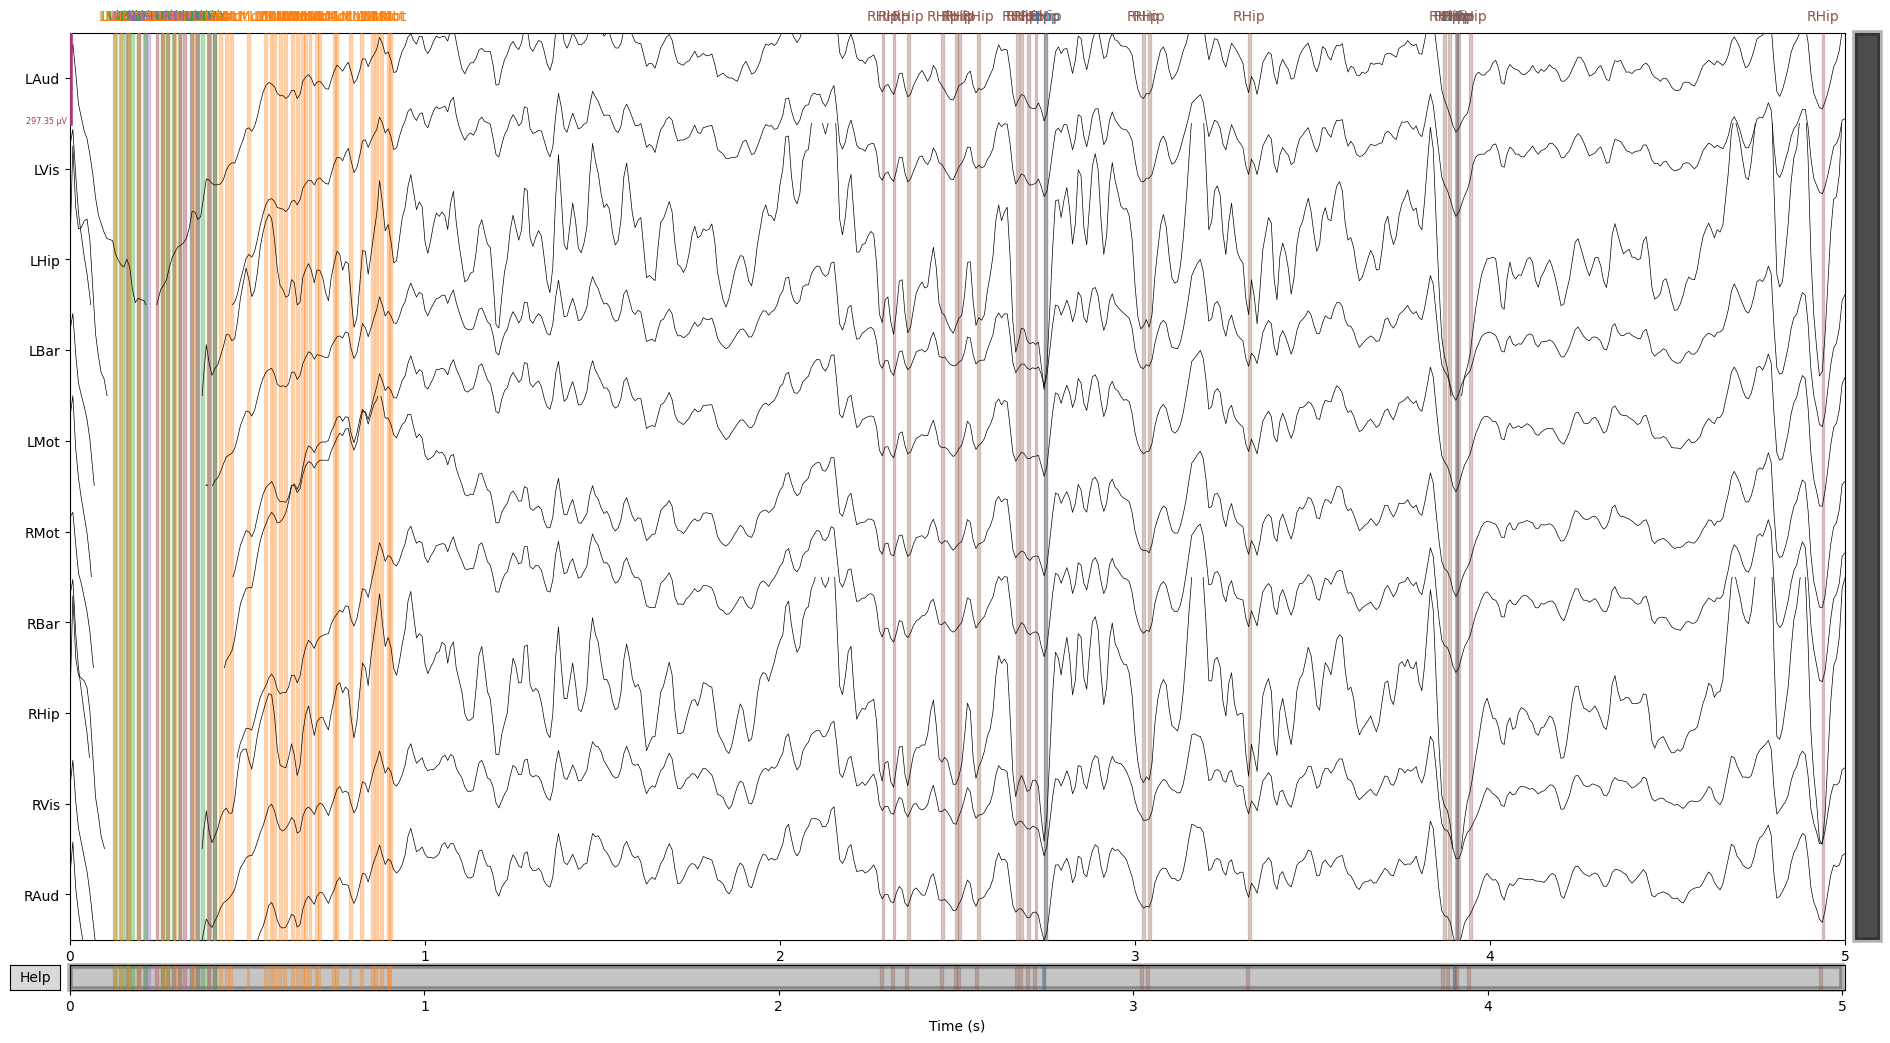

In [18]:
raw = mne_objects[0]

raw.plot(scalings='auto')

In [ ]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
# animal_ids = ['A5']
animal_ids = ['A5', 'A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=True)
    ao.convert_rowbins_to_rec() # paralleization breaks if not enough memory

    # with Client(cluster_window) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    #     war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    # with Client(cluster_spike) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

    # with Client(LocalCluster()) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    sar = ao.compute_spike_analysis(multiprocess_mode='serial')

In [ ]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve())

In [20]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('/Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/A5 WT Dec-13-2023')

# mne_obj = reconstruct_sas.result_mne



# print(mne_obj.info)

# Apply the custom function to your MNE object
#mne_obj.rename_channels(core.utils.clean_channel_name)


Opening raw data file /Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/A5 WT Dec-13-2023/A5-WT-A5 WT Dec-13-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 53625999 =      0.000 ... 53625.999 secs
Ready.
Opening raw data file /Volumes/marsh_single_unit/PythonEEG/notebooks/tests/test-sars-full/A5 WT Dec-13-2023/A5-WT-A5 WT Dec-13-2023-raw-1.fif...
    Reading extended channel information
Isotrak not found
    Range : 53626000 ... 85306199 =  53626.000 ... 85306.199 secs
Ready.


In [ ]:
# Create a list to store all mne objects
mne_objects = []

animal_ids = ['A5', 'A10']

# Get all files for each animal ID
for animal_id in animal_ids:  # ['A5', 'A10']
    # Find all files matching the pattern for this animal
    file_pattern = f'./test-mnes/{animal_id}*'
    animal_files = glob.glob(file_pattern)
    
    print(f"Found {len(animal_files)} files for {animal_id}:")
    for file in animal_files:
        print(f"  - {file}")
        
        # Load each file and add to our list
        try:
            reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json(file)
            mne_obj = reconstruct_sas.result_mne
            
            # Store metadata in the 'temp' dictionary
            if 'temp' not in mne_obj.info:
                mne_obj.info['temp'] = {}
            mne_obj.info['temp']['animal_id'] = animal_id
            mne_obj.info['temp']['file_path'] = file
            
            # Add to our list
            mne_objects.append(mne_obj)
            print(f"  ✓ Successfully loaded")
        except Exception as e:
            print(f"  ✗ Error loading: {str(e)}")

print(f"\nTotal MNE objects loaded: {len(mne_objects)}")


In [ ]:
# Now you can access the metadata like this:
for i, obj in enumerate(mne_objects):
    print(f"Object {i}: Animal {obj.info['temp']['animal_id']}, from {obj.info['temp']['file_path']}")

In [ ]:
events, event_id = mne.events_from_annotations(raw=mne_obj)
#fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

unique_events, counts = np.unique(events[:, 2], return_counts=True)

print("Event counts:")
for event_code, count in zip(unique_events, counts):
    for name, code in event_id.items():
        if code == event_code:
            print(f"{name}: {count}")

In [8]:
def reject_epochs_by_rms(epochs, threshold_sd=2.5, return_scores=True):
    """
    Reject epochs based on RMS amplitude exceeding a threshold in standard deviations,
    computing thresholds separately for each channel.
    
    Parameters:
    -----------
    epochs : mne.Epochs
        The epochs object to clean
    threshold_sd : float
        Threshold in standard deviations from mean RMS
    return_scores : bool
        Whether to return the RMS scores for all epochs and channels
        
    Returns:
    --------
    epochs_clean : mne.Epochs
        The cleaned epochs object
    rejection_info : dict
        Dictionary with rejection statistics
    rms_scores : ndarray (optional)
        RMS amplitude for each epoch and channel if return_scores=True
    """
    import numpy as np
    
    # Make sure data is loaded
    epochs.load_data()
    
    # Get the data
    data = epochs.get_data()
    n_epochs, n_channels, n_times = data.shape
    
    # Compute RMS for each epoch and each channel
    # Formula: RMS = sqrt(mean(x²))
    rms_per_epoch_channel = np.sqrt(np.mean(np.square(data), axis=2))  # shape: (n_epochs, n_channels)
    
    # Compute mean and standard deviation of RMS values for each channel
    rms_mean_per_channel = np.mean(rms_per_epoch_channel, axis=0)
    rms_std_per_channel = np.std(rms_per_epoch_channel, axis=0)
    
    # Set upper and lower thresholds for each channel
    upper_thresh_per_channel = rms_mean_per_channel + threshold_sd * rms_std_per_channel
    lower_thresh_per_channel = rms_mean_per_channel - threshold_sd * rms_std_per_channel
    
    # Find bad epochs per channel
    bad_epochs_mask_per_channel = (rms_per_epoch_channel > upper_thresh_per_channel) | \
                                 (rms_per_epoch_channel < lower_thresh_per_channel)
    
    # An epoch is considered bad if it's bad in any channel
    bad_epochs_mask = np.any(bad_epochs_mask_per_channel, axis=1)
    
    # Get indices of epochs to drop
    bad_indices = np.where(bad_epochs_mask)[0]
    
    # Create a clean copy with the bad epochs dropped
    epochs_clean = epochs.copy().drop(bad_indices)
    
    # Count bad epochs per channel
    bad_epochs_per_channel = np.sum(bad_epochs_mask_per_channel, axis=0)
    percent_bad_per_channel = (bad_epochs_per_channel / n_epochs) * 100
    
    # Overall rejection statistics
    n_epochs_rejected = len(bad_indices)
    percent_rejected = (n_epochs_rejected / n_epochs) * 100
    
    # Create info dictionary
    channel_info = {
        ch_name: {
            'bad_epochs': bad_epochs_per_channel[i],
            'percent_bad': percent_bad_per_channel[i],
            'rms_mean': rms_mean_per_channel[i],
            'rms_std': rms_std_per_channel[i],
            'upper_threshold': upper_thresh_per_channel[i],
            'lower_threshold': lower_thresh_per_channel[i]
        }
        for i, ch_name in enumerate(epochs.ch_names)
    }
    
    rejection_info = {
        'n_epochs_original': n_epochs,
        'n_epochs_rejected': n_epochs_rejected,
        'n_epochs_kept': n_epochs - n_epochs_rejected,
        'percent_rejected': percent_rejected,
        'threshold_sd': threshold_sd,
        'bad_indices': bad_indices,
        'channels': channel_info
    }
    
    # Print rejection statistics
    print(f"Epochs rejection summary:")
    print(f"  Original epochs: {n_epochs}")
    print(f"  Rejected epochs: {n_epochs_rejected} ({percent_rejected:.2f}%)")
    print(f"  Remaining epochs: {n_epochs - n_epochs_rejected}")
    print(f"  Rejection by channel:")
    
    # Sort channels by percent bad
    sorted_channels = sorted(
        epochs.ch_names, 
        key=lambda ch: channel_info[ch]['percent_bad'],
        reverse=True
    )
    
    for ch_name in sorted_channels:
        info = channel_info[ch_name]
        print(f"    {ch_name}: {info['bad_epochs']} epochs ({info['percent_bad']:.2f}%)")
    
    if return_scores:
        return epochs_clean, rejection_info, rms_per_epoch_channel
    else:
        return epochs_clean, rejection_info


def epoch_peri_spike(mne_obj: mne.io.Raw, tmin=-10, tmax=5, baseline=(None, -5), l_freq=1, h_freq=50):

    raw = mne_obj.copy()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    # logging.debug(f"Events: {events}")
    # logging.debug(f"Event dict: {event_dict}")

    # Process each spike type separately
        # logging.debug(f"Processing channel: {channel_name}")
        
    # Create spike-centered epochs
    epochs = mne.Epochs(
        raw,
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        event_repeated='drop',
        preload=False)
    epochs.drop_bad()
    #epochs = random_subsample_epochs(epochs).load_data()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    epochs.filter(l_freq=l_freq, h_freq=h_freq)
    
    return epochs

def plot_peri_spike_evoked(epochs: mne.epochs, tcrop=(-3, 3)):
    
    # Create a figure with subplots for each channel
    n_channels = len(epochs.ch_names)
    fig, axes = plt.subplots(n_channels, 1, figsize=(10, 2*n_channels), sharex=True)

    for ch_idx, ch_name in enumerate(epochs.ch_names):
        evoked = epochs[ch_name].average()
        evoked.crop(tmin=tcrop[0], tmax=tcrop[1])
        evoked.plot(picks=[ch_idx], axes=axes[ch_idx], show=False, spatial_colors=False)
        axes[ch_idx].set_title(ch_name)

    plt.tight_layout()
    plt.show()


def plot_peri_spike_tfr(epochs, l_freq=1, h_freq=50, baseline=(-10, -5), tcrop=(-3, 3), 
                        rescale_method='zscore', fmin=None, fmax=None):
    """
    Plot time-frequency representation around spikes with multiple rescaling options.
    
    Parameters:
    -----------
    epochs : mne.Epochs
        The epoch data around spikes
    l_freq : float
        Lower frequency bound
    h_freq : float
        Upper frequency bound
    baseline : tuple
        Time range to use for baseline (for normalization)
    tcrop : tuple
        Time range to display in plots
    rescale_method : str
        Method for rescaling data:
        - 'log': Apply log10 transform
        - 'db': Convert to decibels relative to baseline (10*log10(data/baseline))
        - 'zscore': Z-score relative to baseline (default)
        - 'percent': Percent change from baseline
        - 'ratio': Ratio relative to baseline (data/baseline)
        - 'none': No rescaling
    fmin : float | None
        Minimum frequency to display (if None, use l_freq)
    fmax : float | None
        Maximum frequency to display (if None, use h_freq)
    
    Returns:
    --------
    fig : matplotlib.Figure
        The figure containing the plots
    """
    # Set frequency range for display
    fmin = l_freq if fmin is None else fmin
    fmax = h_freq if fmax is None else fmax
    
    # Create a figure with subplots for each channel
    n_channels = len(epochs.ch_names)
    fig, axes = plt.subplots(n_channels, 1, figsize=(10, 2*n_channels), sharex=True)
    
    # Ensure axes is always a list for consistent indexing
    if n_channels == 1:
        axes = [axes]
    
    # Frequencies to analyze
    freqs = np.arange(l_freq, h_freq, 1)
    
    # Set colormap based on rescale method
    if rescale_method in ['zscore', 'percent']:
        cmap = 'RdBu_r'  # Diverging colormap for data centered around zero
    else:
        cmap = 'viridis'  # Sequential colormap for non-centered data
    
    for ch_idx, ch_name in enumerate(epochs.ch_names):
        # Compute TFR using Morlet wavelets
        tfr_spike = epochs[ch_name].compute_tfr(
            freqs=freqs, 
            n_cycles=freqs / 2,  # Adjust n_cycles based on frequency 
            method='morlet', 
            use_fft=True, 
            average=True
        )
        
        # Get the data and apply requested transform
        data = tfr_spike.data.copy()
        
        # Handle small/zero values for log transforms
        if rescale_method in ['log', 'db', 'ratio', 'percent']:
            # Add small constant to avoid log(0)
            epsilon = np.finfo(float).eps
            data = np.maximum(data, epsilon)
        
        # Apply selected rescaling method
        if rescale_method == 'log':
            # Simple log10 transform
            data = np.log10(data)
            colorbar_label = 'log₁₀(Power)'
        
        elif rescale_method == 'db':
            # Convert to decibels relative to baseline
            # First compute baseline power
            baseline_mask = ((tfr_spike.times >= baseline[0]) & 
                            (tfr_spike.times <= baseline[1]))
            baseline_data = np.mean(data[:, :, baseline_mask], axis=2, keepdims=True)
            # Then compute dB = 10*log10(data/baseline)
            data = 10 * np.log10(data / baseline_data)
            colorbar_label = 'Power (dB)'
            # Use diverging colormap for dB
            cmap = 'RdBu_r'
        
        elif rescale_method == 'zscore':
            # Z-score relative to baseline using MNE's function
            data = mne.baseline.rescale(
                data,
                tfr_spike.times,
                baseline=baseline,
                mode='zscore'
            )
            colorbar_label = 'Z-score'
        
        elif rescale_method == 'percent':
            # Percent change from baseline
            baseline_mask = ((tfr_spike.times >= baseline[0]) & 
                            (tfr_spike.times <= baseline[1]))
            baseline_data = np.mean(data[:, :, baseline_mask], axis=2, keepdims=True)
            data = 100 * (data - baseline_data) / baseline_data
            colorbar_label = 'Change (%)'
        
        elif rescale_method == 'ratio':
            # Simple ratio to baseline
            baseline_mask = ((tfr_spike.times >= baseline[0]) & 
                            (tfr_spike.times <= baseline[1]))
            baseline_data = np.mean(data[:, :, baseline_mask], axis=2, keepdims=True)
            data = data / baseline_data
            colorbar_label = 'Ratio to baseline'
        
        elif rescale_method == 'none':
            # No rescaling
            colorbar_label = 'Power'
        
        else:
            raise ValueError(f"Unknown rescale method: {rescale_method}")
        
        # Now crop to time range of interest for display
        time_mask = (tfr_spike.times >= tcrop[0]) & (tfr_spike.times <= tcrop[1])
        times_cropped = tfr_spike.times[time_mask]
        data_cropped = data[:, :, time_mask]
        
        # Apply frequency range limits for display
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        freqs_display = freqs[freq_mask]
        data_display = data_cropped[:, freq_mask, :]
        
        # Set limits for better visualization
        if rescale_method in ['zscore', 'percent', 'db']:
            # For methods that produce values centered around zero
            vmin, vmax = np.percentile(data_display, [5, 95])
            # Make the colormap symmetric around zero
            abs_max = max(abs(vmin), abs(vmax))
            vmin, vmax = -abs_max, abs_max
        else:
            # For methods that don't produce values centered around zero
            vmin, vmax = np.percentile(data_display, [5, 95])
        
        # Plot the heatmap
        im = axes[ch_idx].pcolormesh(
            times_cropped, 
            freqs_display, 
            data_display[0, :, :],  # First dimension is epochs/average
            cmap=cmap,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=axes[ch_idx])
        cbar.set_label(colorbar_label)
        
        # Add labels and title
        axes[ch_idx].set_ylabel('Frequency (Hz)')
        if rescale_method == 'none':
            title = f'Channel: {ch_name}'
        else:
            title = f'Channel: {ch_name} ({rescale_method})'
        axes[ch_idx].set_title(title)
        
        # Add vertical line at t=0 (spike time)
        axes[ch_idx].axvline(x=0, color='black', linestyle='--', alpha=0.8)
        
        # # Add horizontal lines at classic frequency bands
        # band_colors = {'theta': 'blue', 'alpha': 'green', 'beta': 'orange', 'gamma': 'red'}
        # band_ranges = {'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}
        
        # for band, (band_min, band_max) in band_ranges.items():
        #     if band_min >= fmin and band_min <= fmax:
        #         axes[ch_idx].axhline(y=band_min, color=band_colors[band], 
        #                             linestyle=':', alpha=0.6)
        #     if band_max >= fmin and band_max <= fmax:
        #         axes[ch_idx].axhline(y=band_max, color=band_colors[band], 
        #                             linestyle=':', alpha=0.6)
    
    # Add global x-axis label
    plt.xlabel('Time (s)')
    plt.tight_layout()
    
    # Add title with rescaling method
    if rescale_method != 'none':
        plt.suptitle(f'Time-Frequency Analysis ({rescale_method})', 
                   fontsize=12, y=1.02)
    else:
        plt.suptitle('Time-Frequency Analysis (unscaled)', 
                   fontsize=12, y=1.02)
    
    return fig
    

Plotting idea
- Plot individual ERP time series (option to select channels, time range)
- Add groupby variable for multiple files

- Night vs. day
    - split up the event
    - sar object has this information (timestamp)
    - use isday function in utils.py

Joseph
- rythmicity plot

In [ ]:
#epochs.plot(scalings = 'auto', n_epochs = 2)

# epochs_clean, rejection_info, rms_per_epoch = reject_epochs_by_rms(epochs, threshold_sd=1)


# plot_peri_spike_evoked(epochs)
# plot_peri_spike_evoked(epochs_clean)


In [ ]:
mne_obj = mne_objects[0]
print(mne_obj.info)

epochs = epoch_peri_spike(mne_obj)

plot_peri_spike_evoked(epochs)

# 1. Plain log10 transform
fig_log = plot_peri_spike_tfr(
    epochs, 
    l_freq=1, 
    h_freq=50, 
    tcrop=(-3, 3),
    rescale_method='log'
)

# 2. dB transform relative to baseline
fig_db = plot_peri_spike_tfr(
    epochs, 
    l_freq=1, 
    h_freq=50, 
    tcrop=(-3, 3),
    rescale_method='db'
)


In [28]:
# quick hack to look at peri-spike EEG

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-10, tmax=5, tcrop=(-3, 3), baseline=(None, -5), l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    tcrop : tuple
        Time range to crop the data (in seconds)
    baseline : tuple
        Time range to compute baseline (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    events, event_dict = mne.events_from_annotations(raw=raw)
    # logging.debug(f"Events: {events}")
    # logging.debug(f"Event dict: {event_dict}")

    # Process each spike type separately
    for channel_name in event_dict.keys():
        # logging.debug(f"Processing channel: {channel_name}")
        
        # Create spike-centered epochs
        epochs = mne.Epochs(
            raw,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            event_repeated='drop',
            # preload=True,
            event_id=channel_name,
        )
        epochs.drop_bad()
        epochs = random_subsample_epochs(epochs).load_data()
        epochs.crop(tmin=tcrop[0], tmax=tcrop[1])
        # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
        epochs.filter(l_freq=l_freq, h_freq=h_freq)

        epochs.compute_psd(fmin=1.0, fmax=80.0).plot(picks="eeg", average = True, exclude="bads", amplitude=False)
        # Plot the epochs
        epochs.plot_image([channel_name])


        
        # logging.info(f"Computing TFR: {channel_name}")
        # with joblib.parallel_config('dask', scheduler_host=cluster_general.scheduler_address):
        #     # epochs.tfr_stockwell(l_freq=l_freq, h_freq=h_freq)
        #     # tfr_spike = epochs.compute_tfr(freqs=(l_freq, h_freq), method='stockwell', average=True)
        #     # TODO take log?
        #     # TODO implement morlet over multitaper, it's cleaner. Follow documentation for exact
        
        tfr_spike = epochs.compute_tfr(freqs=np.arange(l_freq, h_freq, 1), n_cycles=np.arange(l_freq, h_freq, 1) * 2, method='morlet', use_fft=True, average=True)


        tfr_spike.data = np.log10(tfr_spike.data)

        vmin, vmax = np.percentile(tfr_spike.data, [5, 95])  # Using 5th and 95th percentiles

        tfr_spike.plot(picks=[channel_name], baseline=None, mode="logratio", title=channel_name, vlim=(vmin, vmax))


        # Return the objects from the first spike type
        return epochs#, tfr_spike


In [6]:
def plot_tfr_hilbert(epochs: mne.Epochs, freqs: list[float], bandwidth: float):
    data = np.empty((len(epochs), len(epochs.ch_names), freqs.size, epochs.times.size), dtype=complex)
    logging.info(f"data shape: {data.shape}")
    for idx, freq in enumerate(freqs):
        data[:, :, idx] = epochs.get_data()
        
    # TODO implement hilbert transform on narrowband filter

    # power = mne.time_frequency.EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
    # power.average().plot(
    #     [0],
    #     baseline=(0.0, 0.1),
    #     mode="mean",
    #     vlim=(0, 0.1),
    #     axes=ax,
    #     show=False,

        

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")
# bandwidths = [1.0, 2.0, 4.0]
# for bandwidth, ax in zip(bandwidths, axs):
#     data = np.zeros(
#         (len(epochs), len(ch_names), freqs.size, epochs.times.size), dtype=complex
#     )
#     for idx, freq in enumerate(freqs):
#         # Filter raw data and re-epoch to avoid the filter being longer than
#         # the epoch data for low frequencies and short epochs, such as here.
#         raw_filter = raw.copy()
#         # NOTE: The bandwidths of the filters are changed from their defaults
#         # to exaggerate differences. With the default transition bandwidths,
#         # these are all very similar because the filters are almost the same.
#         # In practice, using the default is usually a wise choice.
#         raw_filter.filter(
#             l_freq=freq - bandwidth / 2,
#             h_freq=freq + bandwidth / 2,
#             # no negative values for large bandwidth and low freq
#             l_trans_bandwidth=min([4 * bandwidth, freq - bandwidth]),
#             h_trans_bandwidth=4 * bandwidth,
#         )
#         raw_filter.apply_hilbert()
#         epochs_hilb = Epochs(
#             raw_filter, events, tmin=0, tmax=n_times / sfreq, baseline=(0, 0.1)
#         )
#         data[:, :, idx] = epochs_hilb.get_data()
#     power = EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
#     power.average().plot(
#         [0],
#         baseline=(0.0, 0.1),
#         mode="mean",
#         vlim=(0, 0.1),
#         axes=ax,
#         show=False,
#         colorbar=False,
#     )
#     n_cycles = "scaled by freqs" if not isinstance(n_cycles, int) else n_cycles
#     ax.set_title(
#         "Sim: Using narrow bandpass filter Hilbert,\n"
#         f"bandwidth = {bandwidth}, "
#         f"transition bandwidth = {4 * bandwidth}"
#     )

In [ ]:
# display(mne_obj)
epochs = analyze_peri_spike_tfr(mne_obj)

In [ ]:
epochs.plot(scalings = 'auto', n_epochs = 5)